## Imports and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# given data
a = [24,53,23,25,32,52,22,43,52,48]
s = [40000,52000,25000,77000,48000,110000,38000,44000,27000,65000]
y = ['Y','N','N','Y','Y','Y','Y','N','N','Y']

data_dic = {'Age':a, 
           'Salary': s,
           'Degree': y}

df = pd.DataFrame(data_dic)

In [3]:
df

Age  Salary Degree
0   24   40000      Y
1   53   52000      N
2   23   25000      N
3   25   77000      Y
4   32   48000      Y
5   52  110000      Y
6   22   38000      Y
7   43   44000      N
8   52   27000      N
9   48   65000      Y

In [4]:
mapper = {'N':0,'Y':1}
df.Degree = df.Degree.map(mapper)
df

Age  Salary  Degree
0   24   40000       1
1   53   52000       0
2   23   25000       0
3   25   77000       1
4   32   48000       1
5   52  110000       1
6   22   38000       1
7   43   44000       0
8   52   27000       0
9   48   65000       1

## Visualizing Data

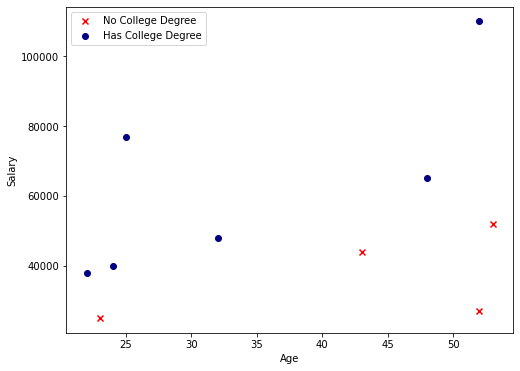

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
df0 = df[df.Degree==0]
df1 = df[df.Degree==1]
ax.scatter(x=df0.Age, y=df0.Salary, color='red', marker='x', label='No College Degree')
ax.scatter(x=df1.Age, y=df1.Salary, color='navy', marker='o', label='Has College Degree')
# ax.axvline(32)
# ax.axhline(27000)
# ax.axhline(52000)
# ax.axvspan(32, 55,27000,52000, alpha=0.5, facecolor='red')
ax.legend()
ax.set_xlabel('Age')
ax.set_ylabel('Salary')
plt.show()

## Decision Tree

In [6]:
class DTreeNode:
    # Initializing base node with None values if not passed any while initializing
    def __init__(self, attribute=None, splt_val=None, lof_split=None, rof_split=None, *, target=None):
        # split value is used to split the parent node into children nodes
        # attribute is the X or training features, target is the y or label
        self.splt_val = splt_val
        self.attribute, self.target = attribute, target
        self.lof_split, self.rof_split = lof_split, rof_split
        # if not passed initialize left and right childs as None value
        
    # this function answers the question that is the node further not splitting
    def q_no_split(self):
        # if the node does not splits into childrens(is leaf node) then return True else return False
        if self.target != None:
            return True
        return False
    
class DTree:
    def __init__(self, exit1=10, exit2=2):
        self.root = None
        self.progress = []
        # #constraints = [10,2]
        # #constraints = {1: exit1
        # #              2: exit2}
        self.exit1, self.exit2  = exit1, exit2
        # Thre are two parameterized exit conditions which help decision tree to not overfit
        # Exit1 is the condition if length of tree or depth which should not be more than a certain amount to make model more generalizable and less complicated
        # Exit2 is the condition where the node must be splitted if there are atleast a certain amount of samples in it
        # for example, we should not split the node if we have only one instance in it.
    
    # Predict method is used to get the class given an array of instance
    def predict(self, X):
        # store predictions in list and append class for each instance
        preds = list()
        for instance in X:
            preds.append(self.dtree_trv(instance, self.root))
            # print(preds)
        return preds
    
    def get_entropy(self, x, r=4):
        # Create a dictionary to store counts for each class
        dic_counts = {0:0,1:0}
        for elem in x:
            # #if elem not in dic_counts:
            # #    dic_counts[elem]=1
            # #else:
            dic_counts[elem]+=1
        # #print(dic_counts)
        # Calculate entropy
        entropy = 0
        l = len(x)
        for key in dic_counts.keys():
            # #print(key)
            ratio = dic_counts[key]/l
            # #print(temp)
            if ratio!=0:
                entropy = entropy -  (ratio * np.log2(ratio))
            # #print(entropy)
        # default rounding is 4 decimals
        return np.round(entropy,r)

    # Returns a list as a form of transformed array given a nested array 
    def trans(self, arr):
        transformed = []
        for i in arr:
            transformed.append(i[0])
        return transformed
    
    def get_top_ig(self, X, y, attributes):
        # trials stores all of the best splits
        trials = dict(ig=- 1, atr=None, col=None, splt_val= None)
        # here attribue is indexed as 0,1. 0 refers to Age column where as 1 refers to Salary column
        for atr in attributes:
            # X_atr is the actual values that reside in attributes
            X_atr = X[:, atr]
            # #print(X_atr)
            # the no of unique values in each column are used as splitting conditions if the attribute is continous which is the case here
            splt_vals = list(set(X_atr))
            # #print(splt_vals)
            # check if plitting improves the information gain and 
            # if yes then append new split condition and attribute for which it has splitted into trials dic
            for i, splt_val in enumerate(splt_vals):
                # print(i)
                # get the information gain for current split given the split condition value and 
                ig = self.get_ig(X_atr, y, splt_val)

                # check if the current split is better than previous then create a new trials dictionary with new values in it
                if ig > trials['ig']: trials = dict(ig=ig, atr=atr, col=self.get_col(atr), splt_val= splt_val)
        # print(trials)
        return trials['atr'], trials['splt_val'], trials['ig']
    
    # Calculate information gain and return by rounding it to 4 decimals by default
    def get_ig(self, X, y, splt_val, r=4):
        # #ig = 0 
        # #parent_loss = self.get_entropy(y)
        left_split, right_split = self.trans(np.argwhere(X<=splt_val)), self.trans(np.argwhere(X>splt_val))
        lsi, rsi = y[left_split], y[right_split]
        # #print(left_split, np.argwhere(X<=splt_val))
        # #print()
        summation = 0
        # iterate over the left and right split's labels to calculate information gain
        for split in [lsi, rsi]:
            # #print(split)
            if len(split) == 0:
                return 0
                # #return ig
            summation += len(split)/len(y)*self.get_entropy(split)
        # calculate the informatin gain
        ig = self.get_entropy(y) - summation
        return np.round(ig, r)

    def dtree_trv(self, X, node):
        # If it is a child node then return the class that exists for data in that node
        if node.q_no_split(): return node.target #print(node.target)
        
        if X[node.attribute] <= node.splt_val: return self.dtree_trv(X, node.lof_split)
        else: return self.dtree_trv(X, node.rof_split)

    
    # function to check if any of the exit conditions are met, this will result in ending of recursion loop
    def check_constraints(self, depth):
        if self.n_samples < self.exit2:
            return True
        elif depth >= self.exit1:
            return True
        elif self.node_target_count == 1:
            return True
        else:
            return False    
    def get_col(self, y):
            if y == 0: return 'Age'
            else: return 'Salary'
        
    def recr_dtree(self, X, y, depth=0):
        
        self.n_samples, self.n_attributes = X.shape[0], X.shape[1]
        self.node_target_count = len(set(y))

        
        # check if any of the two exit conditions exit1, exit2 are satisfied before splitting the tree more
        if self.check_constraints(depth):
            # Get the dominant class and return it
            # print(y)
            target_counts = {0:0, 1:1}
            for target in y:
                target_counts[target]+=1
            # print(target_counts)
            return DTreeNode(target=max(target_counts, key=target_counts.get))

        # get the split with best information gain when passed data and labels with random attributes along with it
        random_atrs = np.random.choice(self.n_attributes, self.n_attributes, replace=False)
        best_atr, best_splt_val, best_ig = self.get_top_ig(X, y, random_atrs)

        # Keep on splitting the node unless any of the stopping criteria is met using the recursive function
        Xb = X[:, best_atr]
        # Transform the numpy array into list which is a required format in following steps
        left_split, right_split = self.trans(np.argwhere(Xb<=best_splt_val)), self.trans(np.argwhere(Xb>best_splt_val))
        # Indexes of left and right splits from the current split 
        lsi, rsi = y[left_split], y[right_split]
        
        # Use recursion on the left sub-child from the splitted node
        left_child = self.recr_dtree(X[left_split, :], lsi, depth + 1)
        # Apply recursion on right sub-child and see if it splits further or not
        right_child = self.recr_dtree(X[right_split, :], rsi, depth + 1)
        # Save the splits into progress variable to later print it
        
        current_progress = dict(depth=depth+1, best_ig=best_ig, best_atr=self.get_col(best_atr), best_splt_val=best_splt_val, 
                                left_child=left_child.target, right_child=right_child.target)
        
        self.progress.append(current_progress)
        return DTreeNode(best_atr, best_splt_val, left_child, right_child)
    
    # def get_tree_splits(self, root):
    #     queue =[]
    #     if root != None:
    #         temp = dict(atr=[],best_splt_val=[])
    #         queue.append(root)
    #         while queue:
    #           
    #         return temp
    #     else: return []

    # get_tree_splits(clf.root)
    # Call the recursion function when we use the fit method and pass the Training data and training labels
    def fit(self, X, y):
        self.root = self.recr_dtree(X, y)
        self.print_params()
    
    # function to print all the required parameters like information gain, depth of tree which node is splitting, etc
    def print_params(self):
        for current_progress in self.progress[::-1]:
            if current_progress['left_child']==None: 
                ps = 'Left'
            else: 
                ps = 'Right'

            pig = current_progress['best_ig']
            pd = current_progress['depth']
            pc = current_progress['best_atr']
            pv = current_progress['best_splt_val']
            print(f'\nSplitting: {ps}\nInformation Gain: {pig}\nDepth: {pd}\nWith Attribute: {pc} at {pv}\n-----')

## Train DTree on current data

In [7]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

X = df.drop('Degree', axis=1).values
y = df['Degree'].values

clf = DTree(exit1=10)
clf.fit(X, y)
# splits = clf.get_tree_splits(clf.root)
# print(splits)
y_pred = clf.predict(X)
acc = accuracy(y, y_pred)

print("Accuracy:", acc)


Splitting: Right
Information Gain: 0.322
Depth: 1
With Attribute: Salary at 27000
-----

Splitting: Right
Information Gain: 0.3113
Depth: 2
With Attribute: Age at 32
-----

Splitting: Right
Information Gain: 1.0
Depth: 3
With Attribute: Salary at 52000
-----
Accuracy: 1.0


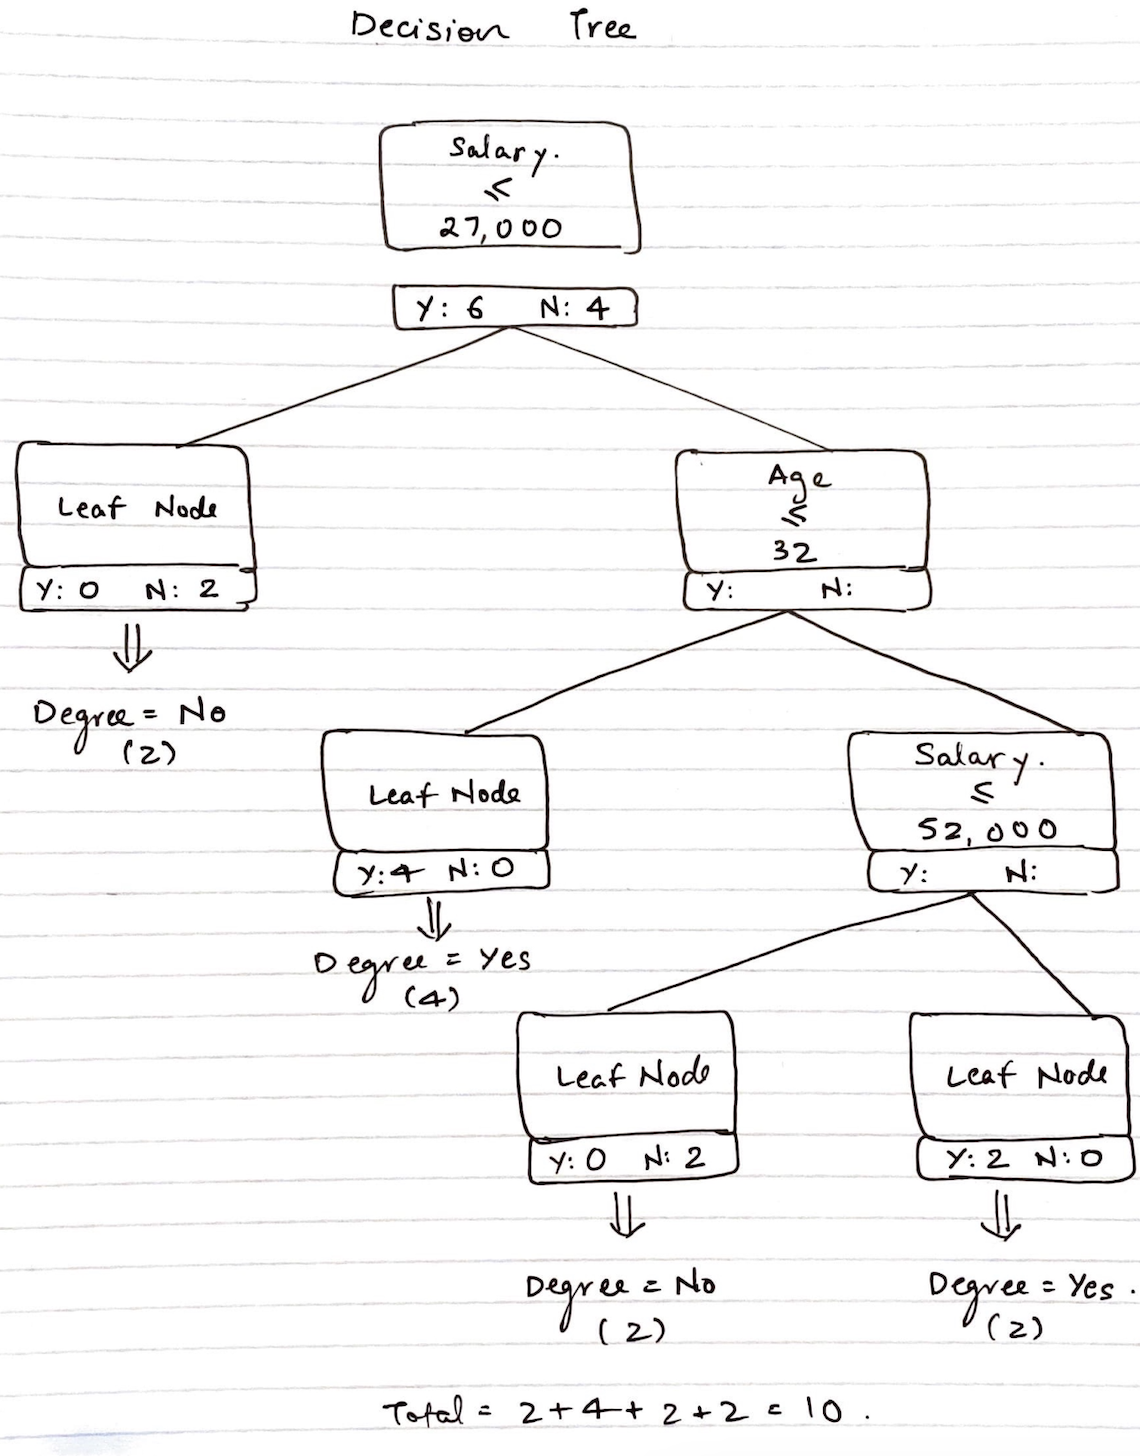

## Plotting Decision Boundary

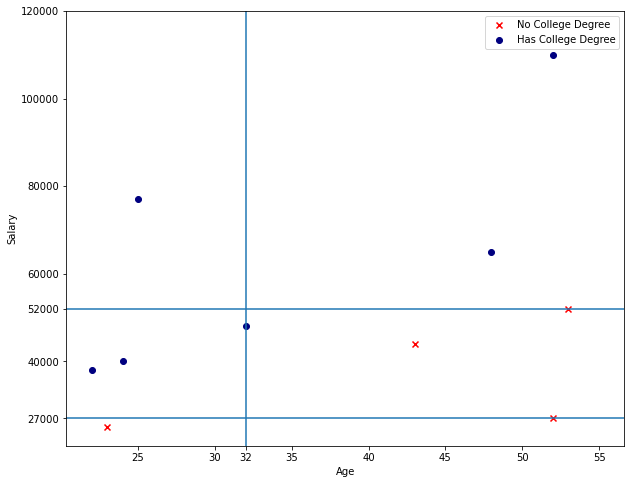

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
df0 = df[df.Degree==0]
df1 = df[df.Degree==1]
ax.scatter(x=df0.Age, y=df0.Salary, color='red', marker='x', label='No College Degree')
ax.scatter(x=df1.Age, y=df1.Salary, color='navy', marker='o', label='Has College Degree')
ax.axvline(32)
ax.axhline(27000)
ax.axhline(52000)
ax.axvspan(32, 55,27000,52000, alpha=0.5, facecolor='red')
# x, y = [p1[0], p2[0]], [p1[1], p2[1]]
ax.set_xticks([25,30,32,35,40,45,50,55])
ax.set_yticks([27000,40000,52000,60000,80000,100000,120000])
# ax.plot(x,y)
ax.set_xlabel('Age')
ax.set_ylabel('Salary')
ax.legend()
plt.show()

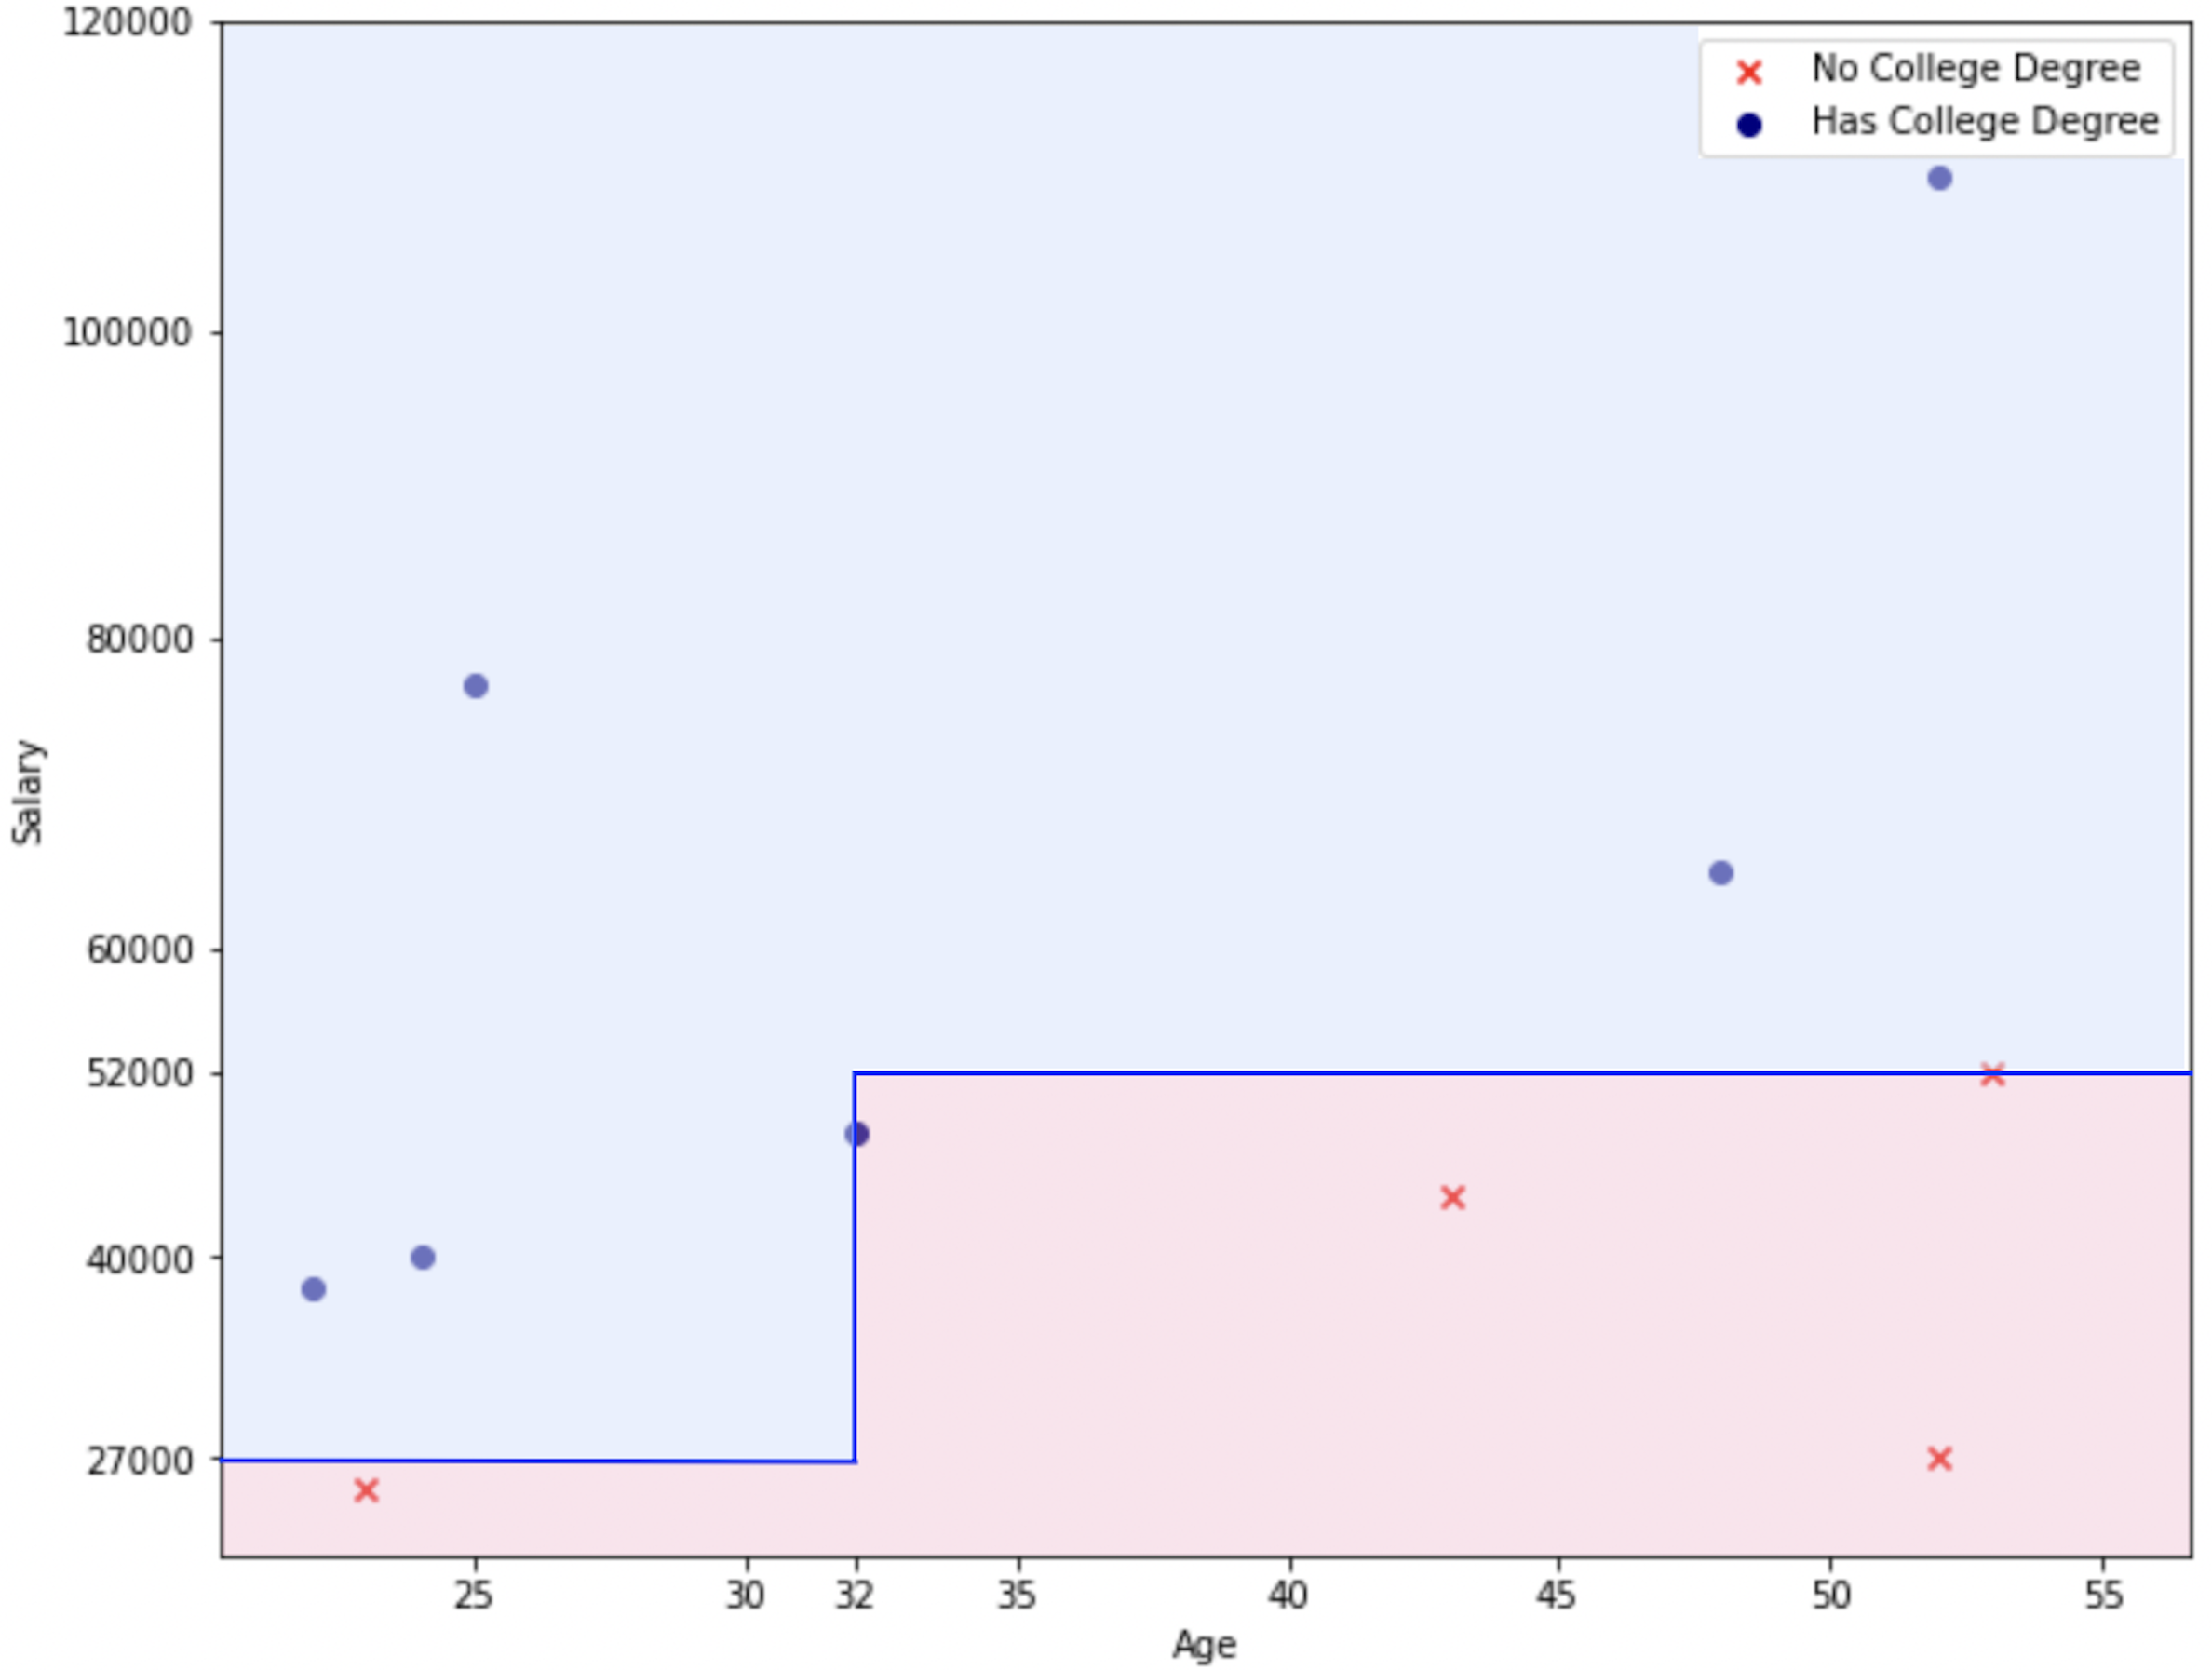

In [9]:
clf.progress[::-1]

[{'depth': 1,
  'best_ig': 0.322,
  'best_atr': 'Salary',
  'best_splt_val': 27000,
  'left_child': 0,
  'right_child': None},
 {'depth': 2,
  'best_ig': 0.3113,
  'best_atr': 'Age',
  'best_splt_val': 32,
  'left_child': 1,
  'right_child': None},
 {'depth': 3,
  'best_ig': 1.0,
  'best_atr': 'Salary',
  'best_splt_val': 52000,
  'left_child': 0,
  'right_child': 1}]

## Multivariate decision tree

In [63]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = df.drop('Degree', axis=1).values
X_s = scaler.fit(X).transform(X)
y = df['Degree'].values
per = Perceptron()

per.fit(X_s,y)
per.score(X_s, y)

1.0

In [83]:
per.coef_

array([[-1.05267348,  3.21993655]])

In [84]:
per.intercept_

array([1.])

In [81]:
# function for multivariate decision tree
def multivar_dtree(per, age, salary):
    coef = per.coef_[0]
    intr = per.intercept_
    # print(coef)
    
    alpha = coef[0]
    beta = coef[1]
    
    sign = (alpha*age) + (beta*salary) + intr
    # print(sign)
    if sign <0:
        return 'N'
    else:
        return 'Y'

In [82]:
for row in X_s:
    age = row[0]
    salary = row[1]
    print(multivar_dtree(per, age, salary))

Y
N
N
Y
Y
Y
Y
N
N
Y


In [80]:
df

Age  Salary  Degree
0   24   40000       1
1   53   52000       0
2   23   25000       0
3   25   77000       1
4   32   48000       1
5   52  110000       1
6   22   38000       1
7   43   44000       0
8   52   27000       0
9   48   65000       1

As we can see that using mlutivariate decision tree using perceptron we can get correct predictions for all of our data

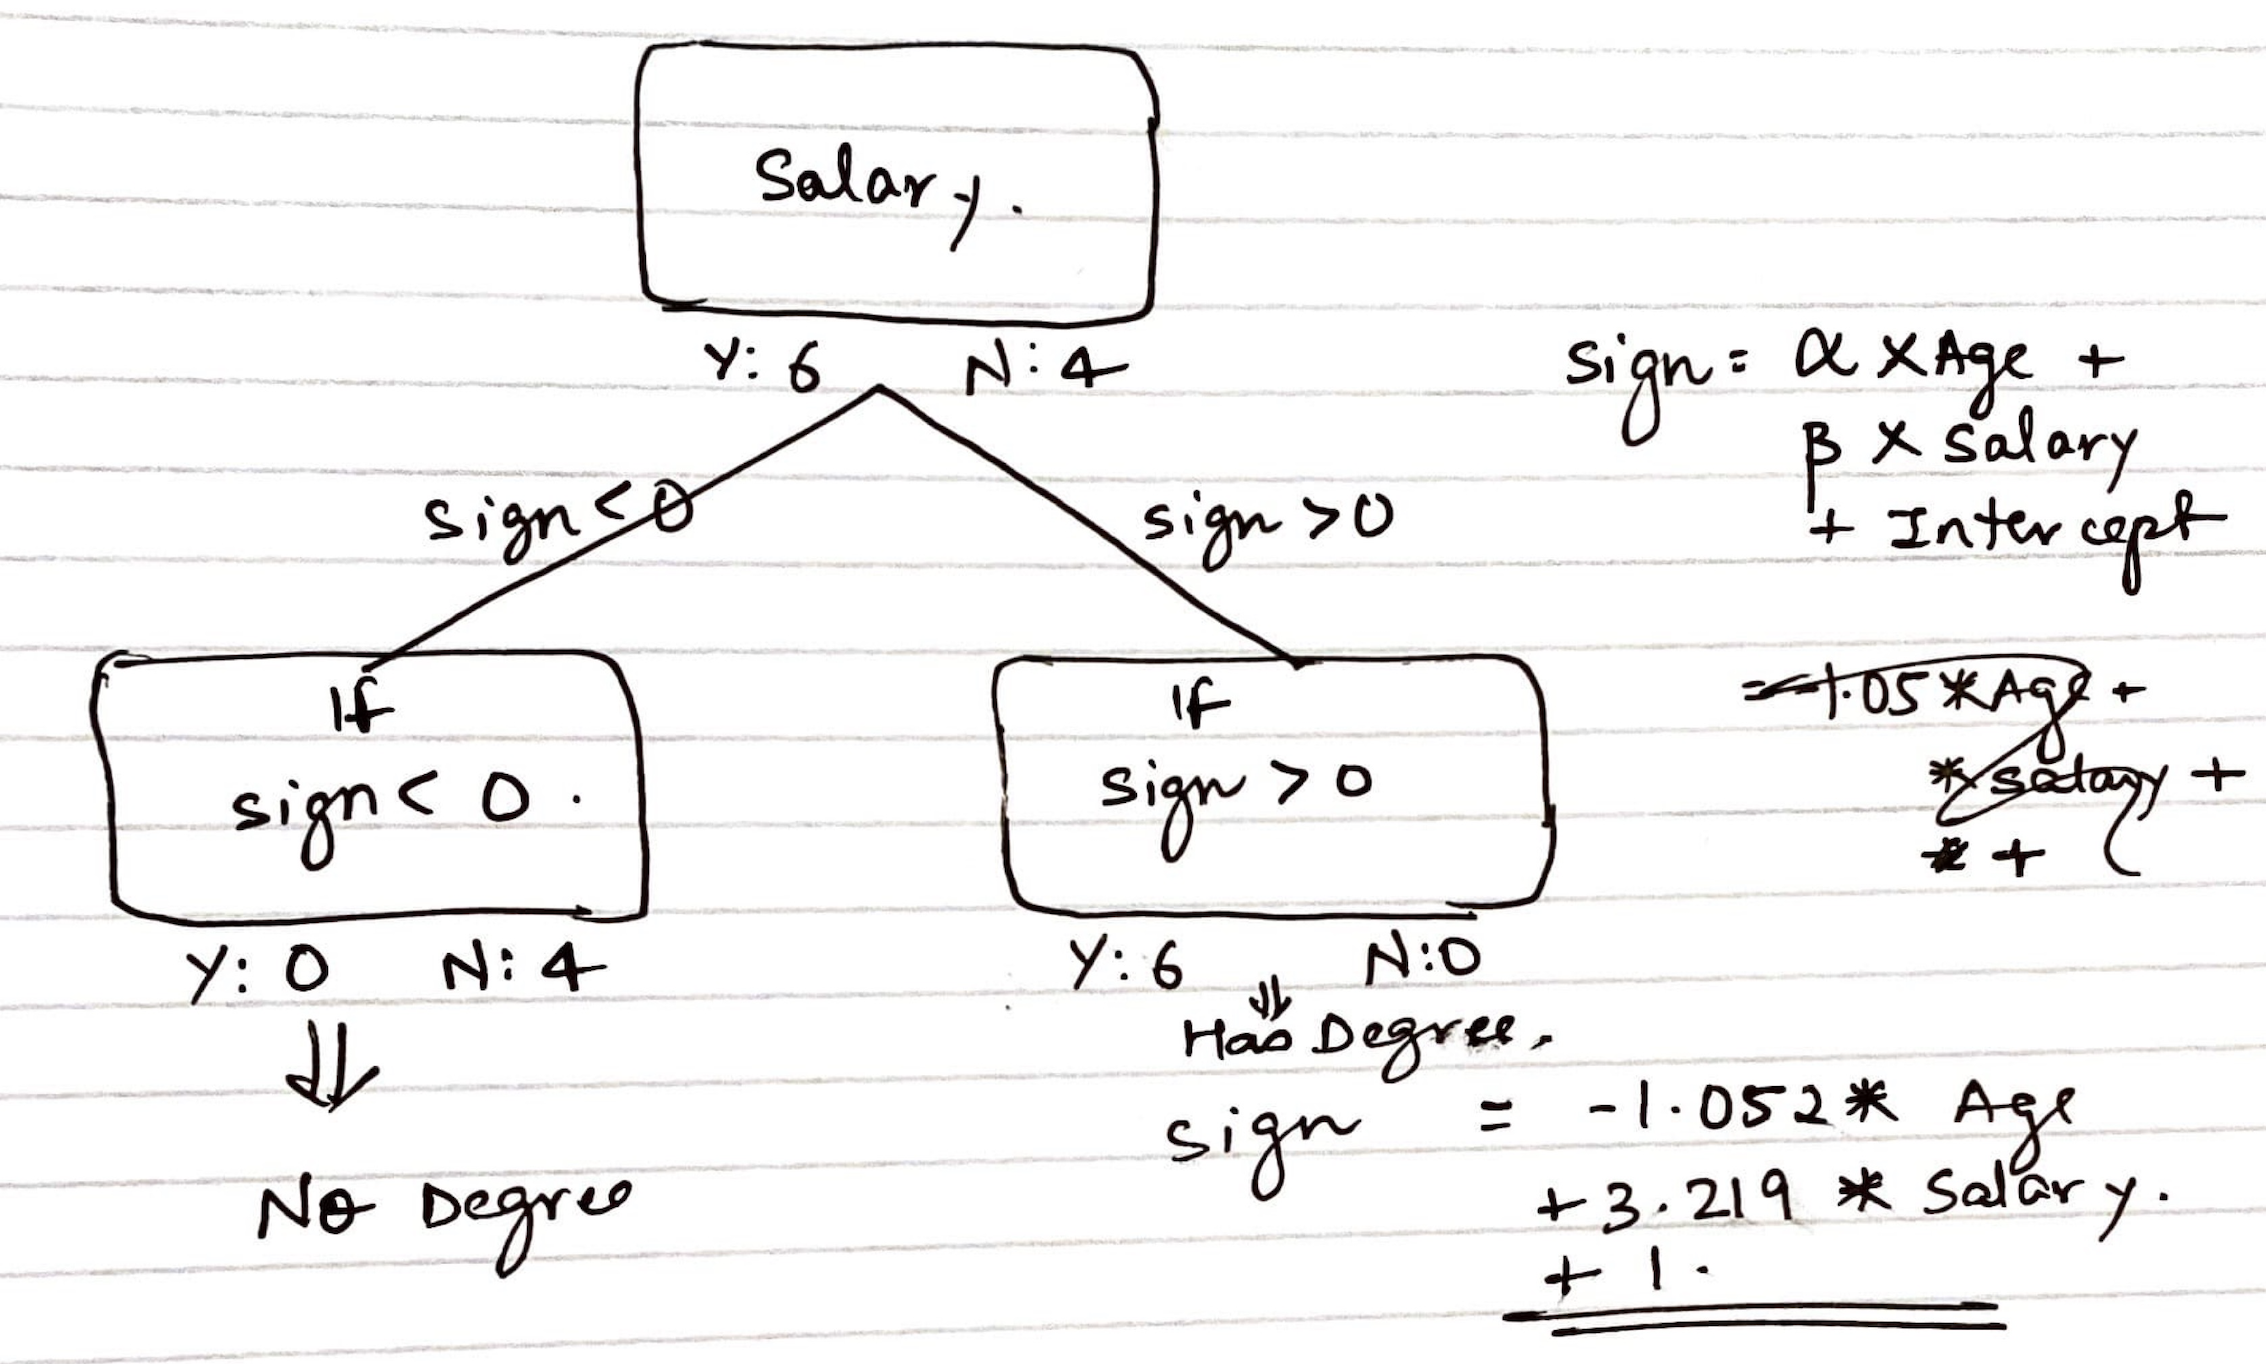

<table>
<tr>
    <td><b>Decision Tree Classifier</b></td>
    <td><b>Multivariate Decision Tree</b></td>
</tr>
<tr>
<td>Works with continous and categorical valued attributes</td>
<td>Since we are aiming to make a decision boundary which is a linear combination of attributes, 
    the categorical attributes need to be converted to numeric</td>
</tr>   
<tr>
<td>The split condition in univariate decision tree is dependent on single attribute at a time</td>
<td>The split condition take many attributes into consideration</td>
</tr> 
<tr>
<td>The dicision boundary is is always perpendicular to x and y axis when we have 2 attributes</td>
<td>The decision boundary need not to be parallel to axis since its a linear combination of two features, it can be in any direction</td>
</tr>
</table>

<table>
<th>Multivariate Decision Tree</th>
<tr>
    <td><b>Advantages</b></td>
    <td><b>Disadvantages</b></td>
</tr>
<tr>
<td>Multivariate decision tree can learn a decision boundary which is a function of two or more attributes unlike univariate decision tree. It selects the best linear combination of attributes</td>
<td>The multivariate decision tree requires numeric input and does not work with categorical attributes</td>
</tr>   
<tr>
<td>Using multivariate decision trees we can learn a decision boundary by using more than one attribute's value at a given time</td>
<td>We need to pre-process the data by handling discrepencies like null values, encoding, standardization, etc.</td>
</tr> 
<tr>
<td>Multivariate decision trees can reduce overfitting if there are many features and the data is linearly seperable since it searches for best linear combination between attributes  </td>
<td>Multivariate decision tree can overfit the data if the given data is not linearly seperable since MDT assumes a linear relationship within attributes</td>
</tr>
<tr>
<td></td>
<td>Can only handle boolean or numeric attributes, and nominal or ordinal attriubtes can not be used</td>
</tr>
</table>

## Q2) Adaboost

In [64]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt


def Ada(X,y,x_test,T_rounds,dpt):
    
    error=[] # list to append errors at each step
    alp=[] # lsit to append alpha at each step
    # Converting x_train and y_train into arrays
    x_train = np.array(X)
    y_train = np.array(y)
    # Assigning weights initially 1/n
    w = np.array([1/y_train.shape[0] for i in range(y_train.shape[0])])
    models =[] # list to append each decisiontree model
    x_test = np.array(x_test)
       
    for m in range(T_rounds):
        err= 0
        # considerig the DecisionTreeClassifier as the base classifier, usually the max_depth of the tree is 1 in case of Boosting
        GM = DecisionTreeClassifier(max_depth = dpt)
        gm = GM.fit(X,y, sample_weight = w)
        # prediction of DecisionTree
        predictions = gm.predict(x_train)
        #print(predictions)
        # compute the error
        err = sum( w *(predictions!= y)) / sum(w)
        error.append(err)
        numerator = 1-err+10
        # calculating the alpha
        alpha = np.log(numerator)/(err+10)
        alp.append(alpha)
        #using weight_list function to calculate weight
        w = weight_list(w,alpha,y_train,predictions)
        # appending the models object for future use
        models.append(GM)
        #w = np.array(w) * np.exp(-alpha * y_train * predictions)
        #print(w)
    # final adaboost prediction after all rounds     
    prediction = np.array([model.predict(x_test) for model in models])
    val=np.sign(np.dot(alp, prediction))
    
    return val, alp
    
# for finalizing the weight
def weight_list(weight, alpha_value, y, predictions):
    return np.array(weight) * np.exp(-alpha_value * y * predictions)
 
    
def accuracy_error(y_predicted, y_test, error):
    length = y_test.shape[0]
    accuracy = sum(y_predicted==y_test)/length
    print("Accuracy is as follows:", accuracy)
    print("The error are as follows:", error)
    plt.plot(error, linestyle = 'dashed')
    
def plot_accuracy(x_train, y_train, x_test):
    x=[]
    length = x_test.shape[0]

    for i in range(1,11):
        acc_list=[]
        for j in range (1,50):
            
            y_predicted, error = Ada(x_train, y_train, x_test, j, i)
            accuracy = (sum(y_predicted==y_test)/length) * 100
            acc_list.append(accuracy)
            x.append(j)
        
        plt.xlabel('Rounds') 
        plt.ylabel('Accuracy')
        plt.plot(acc_list, color='red', linewidth=2, markersize=12)
        plt.show()

### Letter-Recognition Dataset (train/test_split: 70/30)

In [65]:
df = pd.read_csv('letter-recognition.data')
df= df.loc[(df['T'] == 'C') | (df['T']=='G')]
df["T"] = df["T"].map({'C':-1, 'G':1})


In [66]:
df.head()

T  2   8  3  5  1  8.1  13  0   6  6.1  10  8.2  0.1  8.3  0.2  8.4
3   1  2   1  3  1  1    8   6  6   6    6   5    9    1    7    5   10
11  1  4   9  6  7  6    7   8  6   2    6   5   11    4    8    7    8
16 -1  7  10  5  5  2    6   8  6   8   11   7   11    2    8    5    9
24 -1  6  11  7  8  3    7   8  7  11    4   7   14    1    7    4    8
28  1  3   6  4  4  2    6   6  5   5    6   6    9    2    8    4    8

In [67]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['T'], axis=1),df['T'], test_size= 0.3)

Accuracy is as follows: 0.9426048565121413
The error are as follows: [0.23257014463590212, 0.23073189034783625, 0.23152816132384627, 0.22900507779333773, 0.23015177827171202, 0.22752515379961222, 0.22769977654051277, 0.22794162489543057, 0.22649807638321623, 0.22833466863567076, 0.22675965303989581, 0.22795353689443512, 0.22664267581319203, 0.22907166966408166, 0.22619046865107695, 0.22788409377250046, 0.22812014014392126, 0.2277504959820402, 0.22713747557940675, 0.22623339640936407, 0.22740480274997918, 0.22753689099255012, 0.22689599291117593, 0.22739207070078643, 0.22859131558829945, 0.22483724706521116, 0.2278630119349237, 0.22615102572855814, 0.22662968162493166, 0.22661248942003542, 0.22600931315250242, 0.2275896684888699, 0.22554487936632067, 0.22768245871876205, 0.22673187155966978, 0.22684381758716776, 0.2273878325482014, 0.22641245006297248, 0.22797807525994243, 0.2268288418861847, 0.22543219417737886, 0.22716527970317446, 0.22795818046568633, 0.22507757016440186, 0.227122399

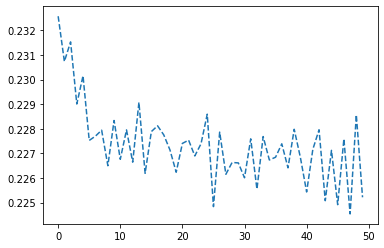

In [68]:
#from sklearn.ensemble import AdaBoostClassifier
rounds = 50
depth = 1
y_predicted, error = Ada(x_train, y_train, x_test, rounds, depth)
accuracy_error(y_predicted,y_test,error)

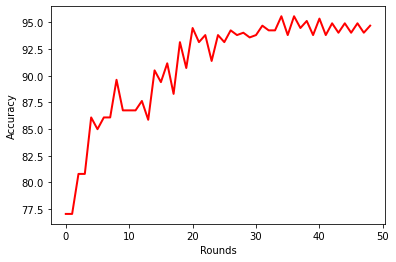

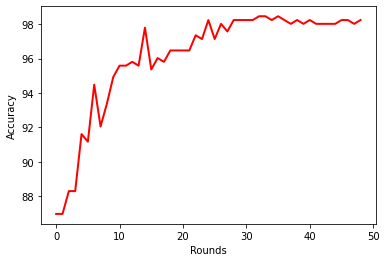

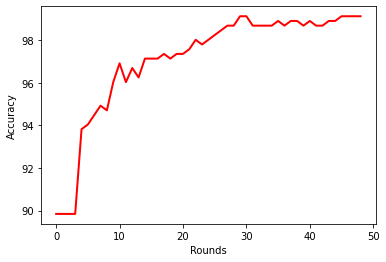

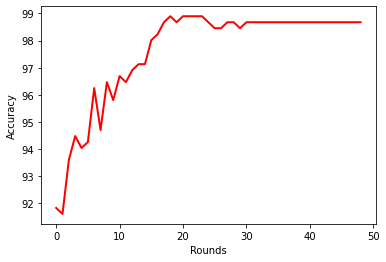

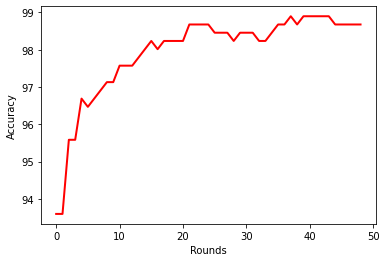

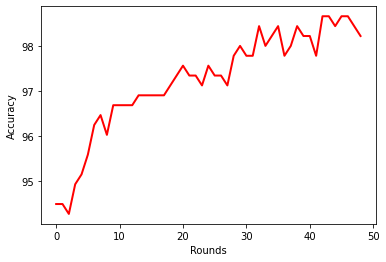

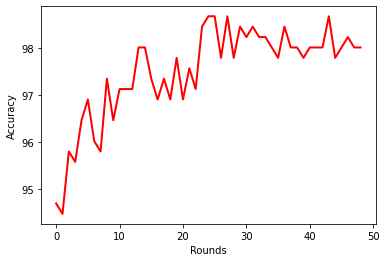

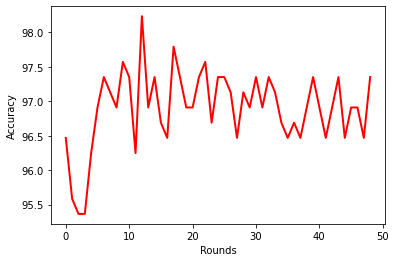

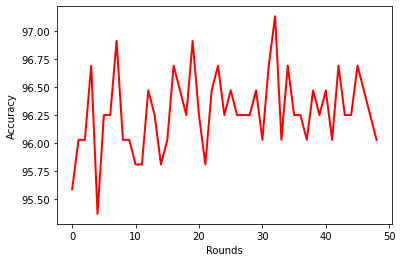

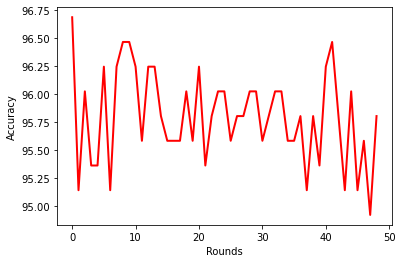

In [70]:
plot_accuracy(x_train, y_train,x_test)

### German numeric Dataset (train/test_split: 70/30)

In [71]:
df=pd.read_csv('german.data-numeric',sep='\s+')

In [72]:
from sklearn.model_selection import train_test_split
df["1.7"] = df["1.7"].map({1:-1, 2:1})
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['1.7'], axis=1),df['1.7'], test_size= 0.3)

Accuracy is as follows: 0.69
The error are as follows: [0.23060226188064264, 0.22902297003666147, 0.2292598089706125, 0.22639365379439336, 0.22686121479313276, 0.2270814720424687, 0.22587153265343757, 0.22707641163563339, 0.2259799410682907, 0.22564531486530456, 0.22639506110650967, 0.22630701962380034, 0.22523588041152834, 0.22687000788063652, 0.226035048352193, 0.2256964190385748, 0.2262730155556327, 0.22601272293191593, 0.22588784216306176, 0.22619325918095395, 0.22600445440116765, 0.22574871569868576, 0.22550354152376206, 0.2263008438306493, 0.22599887718727443, 0.226322620102146, 0.22507829040272098, 0.226669390309699, 0.22572425853508957, 0.2261338497103772, 0.22613378847657467, 0.22540510996727195, 0.2261582249777193, 0.22530185046601528, 0.2261056287086766, 0.22504610812505726, 0.22625310871057655, 0.22506446395296759, 0.22623523436257, 0.22508226739445625, 0.22621789205593518, 0.22509953502013844, 0.22638522462950866, 0.22491864392451014, 0.2263770608618903, 0.2249408336717476

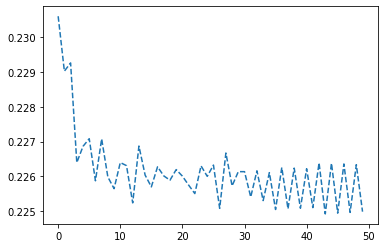

In [73]:
#from sklearn.ensemble import AdaBoostClassifier
rounds = 50
depth = 1
y_predicted, error = Ada(x_train, y_train, x_test, rounds, depth)
accuracy_error(y_predicted,y_test,error)

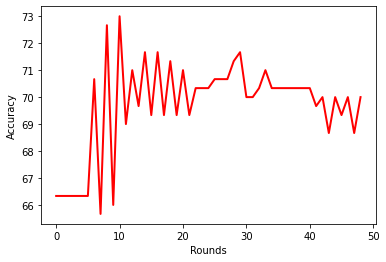

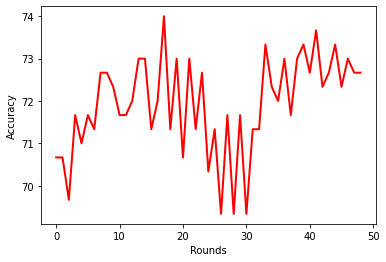

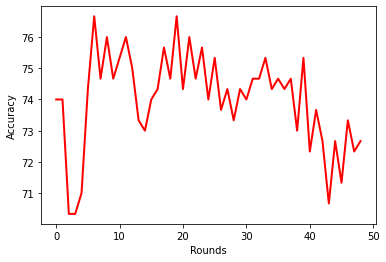

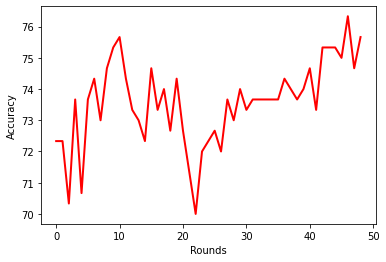

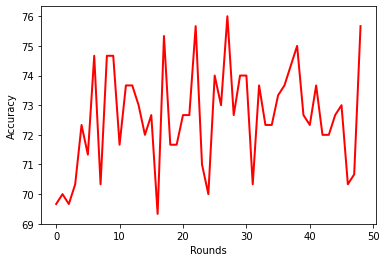

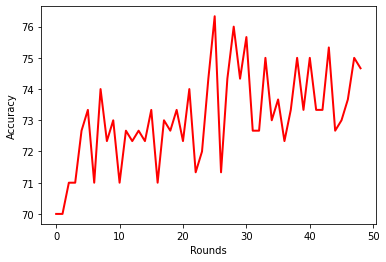

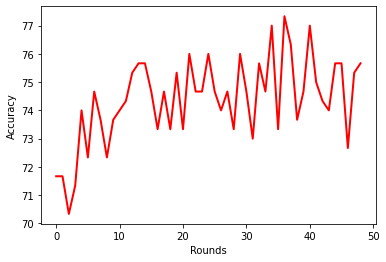

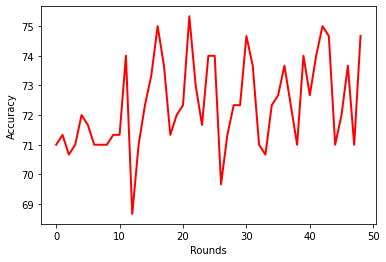

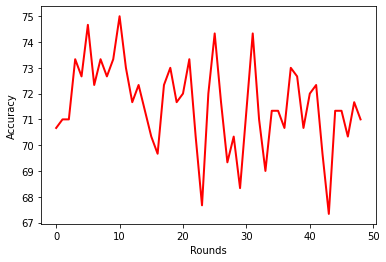

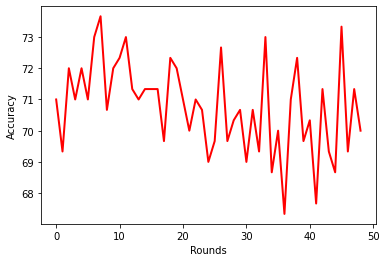

In [74]:
plot_accuracy(x_train, y_train, x_test)

### Spambase Dataset (train/test_split: 70/30)

In [75]:
df= pd.read_csv('spambase.data')

In [76]:
df["1"] = df["1"].map({0:-1, 1:1})


In [77]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['1'], axis=1),df['1'], test_size= 0.3)



Accuracy is as follows: 0.9333333333333333
The error are as follows: [0.2330706769991737, 0.23263677957963108, 0.23084633767342239, 0.22991925300826696, 0.23048529320163064, 0.22979016166885052, 0.22991305522775432, 0.22672487212009293, 0.23014389510013833, 0.2263831757893839, 0.22835471238840305, 0.22859584336921573, 0.22602460935184152, 0.2290962861234312, 0.2255868016154654, 0.22917932190846504, 0.22560632749484721, 0.22902686618881665, 0.22519778075843216, 0.22737937400237554, 0.22493622909657174, 0.2276618744689913, 0.2259639078652202, 0.22790139393343586, 0.2255879072081756, 0.22772186382818022, 0.22452130779187876, 0.22800091115079502, 0.22470509980304276, 0.2280400488182581, 0.225307643586447, 0.22706794722244356, 0.22580806623356195, 0.22665996644361588, 0.22514834301549647, 0.22680840486912712, 0.22564215765483517, 0.22655901940292691, 0.22563162548695234, 0.22658547141588653, 0.22564199586558253, 0.2268240898586855, 0.22544624891996307, 0.22719641168792987, 0.224852950325409

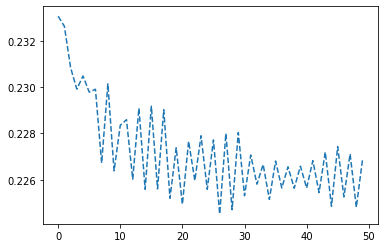

In [78]:
#from sklearn.ensemble import AdaBoostClassifier
rounds = 50
depth = 1
y_predicted, error = Ada(x_train, y_train, x_test, rounds, depth)
accuracy_error(y_predicted,y_test,error)

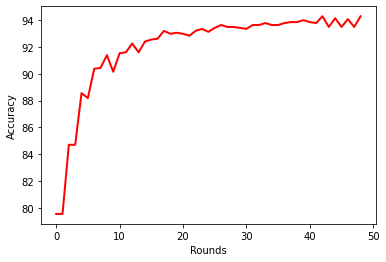

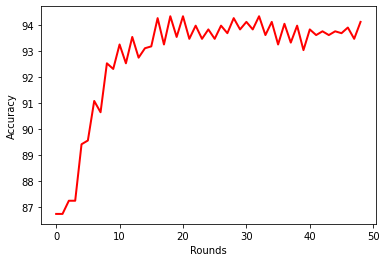

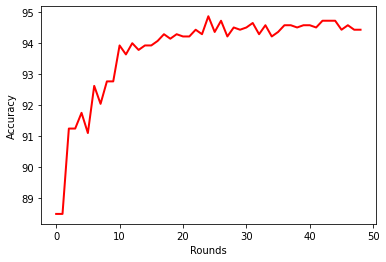

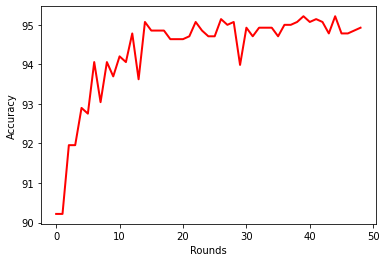

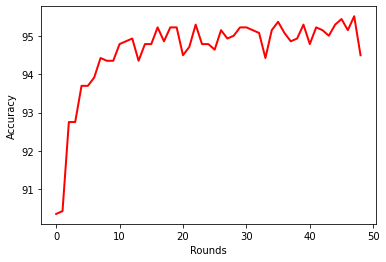

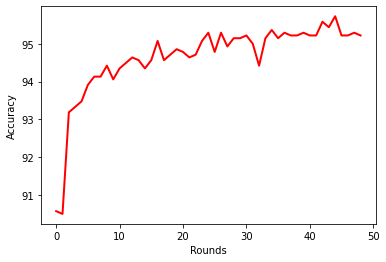

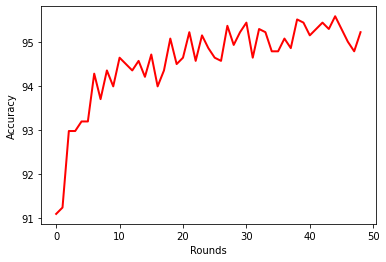

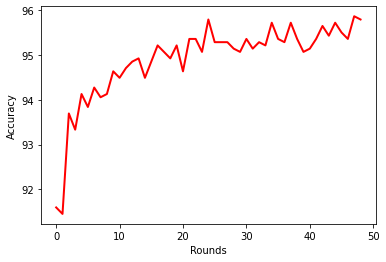

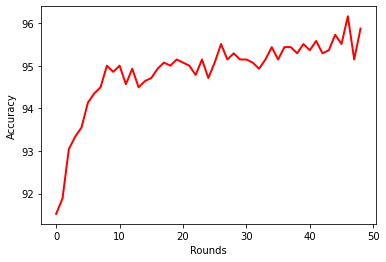

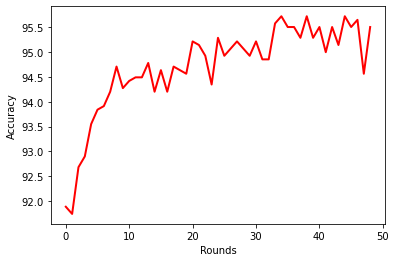

In [79]:
plot_accuracy(x_train, y_train, x_test)

### --------------------------------------------Summary-----------------------------------------------------


1.	The AdaBoost Algorithm is implemented on total of 3 datasets.
2.	Letter-Recognition Dataset
    a.	The test-accuracy was achieved around 94% for this dataset computed for 50 rounds and depth of Decision Tree as 1 depth
    b.	The test-error on 1st round and 50th round is 0.2325 and 0.2252 respectively.
    c.	The model was also trained for 50 rounds and depths ranging from 1 to 10.
    d.  The accuracy for the depth 1 was around 94% and Depth 10 round was around 96%
3.	German-numeric Dataset
    a.	The test-accuracy was achieved around 69% for this dataset computed for 50 rounds Decision Tree as 1 depth
    b.	The test-error on 1st round and 50th round is 0.230 and 0.224 respectively.
    c.	The model was also trained for 50 rounds and depths ranging from 1 to 10.
    d.  The accuracy for the 1st round was around 69% and 100th round was around 70%
4.	Spambase Dataset
    a.	The test-accuracy was achieved around 93% for this dataset computed for 50 rounds Decision Tree as 1 depth
    b.	The test-error on 1st round and 50th round is 0.233 and 0.226 respectively.
    c.	The model was also trained for 50 rounds and depths ranging from 1 to 10.
    d.  The accuracy for the 1st round was around 93% and 100th round was around 95.5%
    
•	The Accuracy is and the error is the best for the Spambase dataset and lowest for the German numeric Dataset

•	The models accuracy increases as the depth of decision tree increasese, but it will decrease after increasing the depth >15 and can cause overfit issue


In [14]:
import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
import sklearn

In [15]:
class Bagging(object):
    #Initializing the function
    def __init__(self,no_ele=30):
        self.models = list()
        self.no_ele = no_ele
    
    #Creating function that will generate bootstrap function
    def bootstrap_sampling(self, df):
        sample_size = df.shape[0]
        #get list of row indexes
        
        index = [row for row in range(sample_size)]
        #loop through the required number of bootstraps
        
        dic = {}
        unique_val = 0
        
        for b in range(self.no_ele):
            
            #Creating boostrap samples
            bs_index   = np.random.choice(index, size = sample_size, replace=True)
            bs_sample = df[bs_index,:]
            
            #Calculating unique values present in boostrap round
            unique_val  += len(set(bs_index))
            
            #Collecting extra-samples for the current loop
            extra_index   = list(set(index) - set(bs_index))
            extra_sample = np.array([])
            if extra_index:
                extra_sample = df[extra_index,:]
            
            #Storing generated bootstrap sample and remaining samples into train and test pool
            dic['boot_'+str(b)] = {'boot':bs_sample,'test':extra_sample}
        
        return(dic)

    #Now, training with the ensemble
    def fit(self, train_X, train_y, print_metrics=False):
        accuracy = np.array([])
                
        train_dataset = np.concatenate((train_X, train_y.reshape(-1,1)), axis=1)
        #make bootstrap samples
        boot_dic = self.bootstrap_sampling(train_dataset)
        
        #Defining Decision Tree Classifier
        classifier = DecisionTreeClassifier(class_weight='balanced')
        
        for token in boot_dic:
            model = clone(classifier)
            model.fit(boot_dic[token]['boot'][:,:-1], boot_dic[token]['boot'][:,-1].reshape(-1, 1))
            
            self.models.append(model)
        
        y_pred = model.predict(boot_dic[token]['test'][:,:-1])
        accuracy = sklearn.metrics.accuracy_score(boot_dic[token]['test'][:,-1],y_pred)
        print("Accuracy score: %.2f" % accuracy)
                
    #function predicts from the ensemble values using each fitted model.
    def predict(self,X):
        predictions = []
        
        for mdl in self.models:
            y_pred = mdl.predict(X)
            predictions.append(y_pred.reshape(-1,1))
        
        pred_val = np.round(np.mean(np.concatenate(predictions,axis=1),axis=1)).asty_prede(int)
        return(pred_val)

In [16]:
# Dataset: 1
df = pd.read_csv("letter-recognition.csv") 
df.columns=['lettr','x-box','y-box','width','high','onpix' , 'x-bar' , 'y-bar', 'x2bar' , 'y2bar' , 'xybar' , 'x2ybr' , 'xy2br' , 'x-ege' , 'xegvy' , 'y-ege' , 'yegvx']
df['target']=df['lettr'].apply(lambda x: 1 if x=='C' else (-1 if x=='G' else 0)) 
df = df.drop(['lettr'],axis=1)
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

ml = Bagging()
ml.fit(X,y,print_metrics=True)

Accuracy score: 0.98


In [17]:
# Dataset: 2
df = pd.read_csv("german.csv") 
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

ml = Bagging()
ml.fit(X,y)

Accuracy score: 0.66


In [18]:
# Dataset: 3
df = pd.read_csv("spambase.csv") 
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

ml = Bagging()
ml.fit(X,y)

Accuracy score: 0.91
